## Feature Engineering and Modelling

This notebook shows the pipeline I used for generating the most recent model being used on pikkit.site.

Arriving at this script was an evolving process of doing feature engineering, selecting the most informative features, and iterating until I arrived at a useful model. For illustrative purposes and for my own reference, I have left a couple of the feature sets from previous iterations in the script.

In [1]:
# General Data analysis tools and utils

import utils
import pandas
import numpy as np
from scipy import misc
import matplotlib.pyplot as plt

from datetime import datetime, date

from scipy.misc import imresize
import features

import json

In [2]:
# Regression models and performance metrics

from sklearn import linear_model, datasets
from sklearn.metrics import mean_squared_error as MSE, r2_score as R2S
from sklearn.isotonic import check_increasing

from scipy.stats import pearsonr

In [3]:
# Control verbosity of script's outputs
verbose = 0

List of users

    anamaria16          eightturncrepeny  iceandvice             minastaartenwereld  taiyakinyc
    cake.and.sweets.17  ezgipolat         instagram-scraper.log  muradosmann         way_cake
    carlifestyle        garrylarduinat    jacquesgenin           omjsk               zachking
    carolina_nusadua    gunopark          jamesjeanart           pierreherme
    cedricgrolet        helloemilie       joannagaines           pollykosheleva
    danbilzerian        hungrygrls        lolly_cakery           somepaintings
    dinarakasko         iamdessertlover   menwithstreetstyle     stuffbeneats

List of tags

    posts3_cake_1505409284.json        posts_icecream_1505846777.json
    images_cake_1505409284.npy         posts3_cakes_1505469028.json     posts_latte_1505845000.json
    images_cakes_1505441948.npy        posts3_icecream_1505846777.json

In [4]:
"""
Load Data
"""

userSpecific = False

# If only looking at a single user, set up data and models to use a limited set of metadata features
# e.g. the number of followers and the average number of likes should not be used

if userSpecific:
    posts,images = utils.dataFromScraper('jamesjeanart')
    dfp = pandas.DataFrame(posts)
    bytag = False

# If looking at multiple users, set things up to use all features

else:
    bytag = True
    posts, images = utils.getData('posts_cakes_1505469028.json',updated=True,rawimages=True)
    with open('data/users_cakes_1505469028.json','r') as infile:
            users = json.load(infile)
    dfu = pandas.DataFrame(users)
    dfp = pandas.DataFrame(posts)

In [6]:
"""
Get features from raw data
"""

# Extract image features:
#  - saturation
#  - contrast
#  - composition (defined by combinations of image kernels)

nbins = 20
nposts0 = len(posts)
satH = np.zeros([nposts0,nbins])
conH = np.zeros([nposts0,nbins])
sat = np.zeros(nposts0)
contrast = np.zeros(nposts0)

# For old method of extracting image 'composition'
dims = 5
comp = np.zeros([nposts0,dims**2])

# New method of extracting composition
kernelCos,kernelSin,kernelCor1,kernelCor2,kernelCor3,kernelCor4 = features.compKernels(dims)
kCos = np.zeros(nposts0)
kSin = np.zeros(nposts0)
kCor1 = np.zeros(nposts0)
kCor2 = np.zeros(nposts0)
kCor3 = np.zeros(nposts0)
kCor4 = np.zeros(nposts0)

for i in range(len(posts)):
    satH[i],_ = np.histogram(features.colorfulness(images[i]), bins=nbins)  # Histogram of saturation
    satH[i] = satH[i]/np.sqrt(np.sum(satH[i]**2)) 
    sat[i] = np.mean(features.colorfulness(images[i]))                      # Saturation 
    intensity = np.mean(images[i],2)                                        # Brightness of image (not informative)
    conH[i],_ = np.histogram(intensity, bins=nbins)                         # Histogram of contrast
    conH[i] = conH[i]/np.sqrt(np.sum(conH[i]**2))
    contrast[i] = features.contrast(images[i])                              # Contrast
    comp[i] = imresize(intensity,[dims,dims]).reshape([dims**2])            # Old method for composition

    temp = imresize(intensity,[dims,dims])                                  # New method fof composition
    kCos[i] = np.mean(temp*kernelCos)                                       # i.e. use Kernels
    kSin[i] = np.mean(temp*kernelSin)
    kCor1[i] = np.mean(temp*kernelCor1)
    kCor2[i] = np.mean(temp*kernelCor2)
    kCor3[i] = np.mean(temp*kernelCor3)
    kCor4[i] = np.mean(temp*kernelCor4)
    

# Extract metadata features:
#  - no. of likes
#  - no. of hastags
#  - no. of followers
#  - no. of followees
#  - total no. of posts
#  - average no. of likes 
#  - hour of day (one hot encoded)
#  - day of week (one hot encoded)
#  - post has multiple images

# These features should be self explanatory
# See features.py for details on how they work

likes = features.likesFromPandas(dfp)
ntags = features.ntagsFromPandas(dfp)

if userSpecific:
    hour = dfp[u'createdtime'].apply(lambda x: features.extractTimeData(x)[1]).values
    weekday = dfp[u'createdtime'].apply(lambda x: features.extractTimeData(x)[0]).values

if bytag:
    followers = dfu['followers'].apply(lambda x: float( features.convertString(x) )).values
    following = dfu['following'].apply(lambda x: features.convertString(x)).values
    user_nposts = dfu[u'nposts'].apply(lambda x: features.getnposts(x)).values
    hour = dfp[u'date'].apply(lambda x: features.extractTimeData(x)[1]).values
    weekday = dfp[u'date'].apply(lambda x: features.extractTimeData(x)[0]).values
    meanlikes = dfu[u'meanlikes'].values
    mult = dfp[u'ismultiple'].values

# One hot encode the weekday and hour
a = np.array([1, 0, 3])
weekdayvec = np.zeros([nposts0,8])
hourvec = np.zeros([nposts0,26])
weekdayvec[np.arange(nposts0), weekday] = 1
hourvec[np.arange(nposts0), hour] = 1


In [7]:
counter = 0
meanlikes2 = meanlikes
for i in range(nposts0):
    if np.isnan(meanlikes[i]):
        counter+=1
        meanlikes2[i] = 0.
print counter
print np.mean(meanlikes2)

73
4.6558159308


In [7]:
"""
Normalize data
"""
    
# Vectorize data

if False:
    
    # Feature set for neural network model
    # Note that the image features have been transformed to 3rd order polynomials
    
    nfeatures = 3*(1+2+4+1+1+1)+7+24+4+1
    nMetaFeatures = 7+24+4+1
    data = np.zeros([nposts0,nfeatures])
    data[:,0] = kCos
    data[:,1] = kSin
    data[:,2] = np.abs(kSin)
    data[:,3] = kCor1
    data[:,4] = kCor2
    data[:,5] = kCor3
    data[:,6] = kCor4
    data[:,7] = sat
    data[:,8] = contrast
    data[:,9] = ntags
    data[:,10] = kCos**2
    data[:,11] = kSin**2
    data[:,12] = np.abs(kSin)**2
    data[:,13] = kCor1**2
    data[:,14] = kCor2**2
    data[:,15] = kCor3**2
    data[:,16] = kCor4**2
    data[:,17] = sat**2
    data[:,18] = contrast**2
    data[:,19] = ntags**2
    data[:,20] = kCos**3
    data[:,21] = kSin**3
    data[:,22] = np.abs(kSin)**3
    data[:,23] = kCor1**3
    data[:,24] = kCor2**3
    data[:,25] = kCor3**3
    data[:,26] = kCor4**3
    data[:,27] = sat**3
    data[:,28] = contrast**3
    data[:,29] = ntags**3
    data[:,30:37] = weekdayvec[:,0:7]
    data[:,37:61] = hourvec[:,0:24]
    data[:,61] = mult
    data[:,62] = followers
    data[:,63] = following
    data[:,64] = user_nposts
    data[:,65] = meanlikes2

elif bytag:
    
    # Feature set for linear regression model, for general users

    nfeatures = 1+2+4+1+1+1+7+24+4+1
    nMetaFeatures = 7+24+4+1
    data = np.zeros([nposts0,nfeatures])
    data[:,0] = kCos
    data[:,1] = kSin
    data[:,2] = np.abs(kSin)
    data[:,3] = kCor1
    data[:,4] = kCor2
    data[:,5] = kCor3
    data[:,6] = kCor4
    data[:,7] = sat
    data[:,8] = contrast
    data[:,9] = ntags
    data[:,10:17] = weekdayvec[:,0:7]
    data[:,17:41] = hourvec[:,0:24]
    data[:,41] = mult
    data[:,42] = followers
    data[:,43] = following
    data[:,44] = user_nposts
    data[:,45] = meanlikes2

else:
    
    # Feature set for linear regression model, only for a single user
    
    nfeatures = 1+2+4+1+1+1+7+24+4+1
    data = np.zeros([nposts0,nfeatures])
    data[:,0] = kCos
    data[:,1] = kSin
    data[:,2] = np.abs(kSin)
    data[:,3] = kCor1
    data[:,4] = kCor2
    data[:,5] = kCor3
    data[:,6] = kCor4
    data[:,7] = sat
    data[:,8] = contrast
    data[:,9] = ntags
    data[:,10:17] = weekdayvec[:,0:7]
    data[:,17:] = hourvec[:,0:24]




# Set normalization bounds

minvals = np.zeros([nfeatures])
maxvals = np.ones([nfeatures])
centervals = np.zeros([nfeatures])

min_y = min(likes)
max_y = max(likes)
center_y = min(likes)

if False:
    
    # Bounds for neural network model
    
    minvals[0] = np.min(data[:,0])
    minvals[1] = np.min(data[:,1])
    minvals[7] = np.min(data[:,7])
    minvals[8] = np.min(data[:,8])
    minvals[9] = np.min(data[:,9])
    for i in (np.arange(20)+10).tolist():
        minvals[i] = np.min(data[:,i])
    minvals[54] = np.min(user_nposts)
    minvals[55] = np.min(meanlikes2)

    maxvals[0] = np.max(data[:,0])
    maxvals[1] = np.max(data[:,1])
    maxvals[2] = np.max(data[:,2])
    maxvals[3] = np.max(data[:,3])
    maxvals[4] = np.max(data[:,4])
    maxvals[5] = np.max(data[:,5])
    maxvals[6] = np.max(data[:,6])
    maxvals[7] = np.max(data[:,7])
    maxvals[8] = np.max(data[:,8])
    maxvals[9] = np.max(data[:,9])
    for i in (np.arange(20)+10).tolist():
        maxvals[i] = np.max(data[:,i])
    maxvals[52] = followers[ followers.argsort()[int(nposts0*.85)] ]
    maxvals[53] = following[ following.argsort()[int(nposts0*.85)] ]
    maxvals[54] = np.max(user_nposts)
    maxvals[55] = np.max(meanlikes2)

    centervals[0] = np.mean(kCos)
    centervals[1] = np.mean(kSin)
    centervals[2] = np.mean(data[:,2])
    centervals[3] = np.mean(data[:,3])
    centervals[4] = np.mean(data[:,4])
    centervals[5] = np.mean(data[:,5])
    centervals[6] = np.mean(data[:,6])
    centervals[7] = np.min(sat)
    centervals[8] = np.min(contrast)
    centervals[9] = np.mean(ntags)
    for i in (np.arange(20)+10).tolist():
        centervals[i] = np.mean(data[:,i])
    centervals[52] = np.mean(data[:,52])
    centervals[53] = np.mean(data[:,53])
    centervals[54] = np.mean(data[:,54])
    centervals[55] = np.mean(data[:,55])

elif bytag:
    
    # Bounds for linear regression model
    
    minvals[0] = np.min(kCos)
    minvals[1] = np.min(kSin)
    minvals[7] = np.min(sat)
    minvals[8] = np.min(contrast)
    minvals[9] = np.min(ntags)

    maxvals[0] = np.max(kCos)
    maxvals[1] = np.max(kSin)
    maxvals[2] = np.max(np.abs(kSin))
    maxvals[3] = np.max(kCor1)
    maxvals[4] = np.max(kCor2)
    maxvals[5] = np.max(kCor3)
    maxvals[6] = np.max(kCor4)
    maxvals[7] = np.max(sat)
    maxvals[8] = np.max(contrast)
    maxvals[9] = np.max(ntags)
    maxvals[42] = followers[ followers.argsort()[int(nposts0*.85)] ]
    maxvals[43] = following[ following.argsort()[int(nposts0*.85)] ]
    maxvals[44] = np.max(user_nposts)
    maxvals[45] = np.max(meanlikes2)

    centervals[0] = np.mean(kCos)
    centervals[1] = np.mean(kSin)
    centervals[7] = np.min(sat)
    centervals[8] = np.min(contrast)
    centervals[9] = np.mean(ntags)

else:
    
    # bounds for user-specific linear regression model
    
    minvals[0] = np.max(kCos)
    minvals[1] = np.max(kSin)
    minvals[2] = np.max(np.abs(kSin))
    minvals[3] = np.max(kCor1)
    minvals[4] = np.max(kCor2)
    minvals[5] = np.max(kCor3)
    minvals[6] = np.max(kCor4)
    minvals[7] = np.max(sat)
    minvals[8] = np.max(contrast)
    minvals[9] = np.max(ntags)

    maxvals[0] = np.min(kCos)
    maxvals[1] = np.min(kSin)
    maxvals[7] = np.min(sat)
    maxvals[8] = np.min(contrast)
    maxvals[9] = np.min(ntags)

    centervals[0] = np.mean(kCos)
    centervals[1] = np.mean(kSin)
    centervals[7] = np.min(sat)
    centervals[8] = np.min(contrast)
    centervals[9] = np.mean(ntags)

    
    

# Normalize data

for i in range(nfeatures):
    data[:,i] = (data[:,i] - centervals[i]) / (maxvals[i] - minvals[i])
    
y_orig = (likes - center_y) / (max_y - min_y)


With all features:
MSE: 0.000008
R2S: 0.808259
Features by order of importance: 
[45 42 44  9  0  6  4  7 13 10 11 12 19 18 17 16 20 21 33 28 29 26 24 25 31
 38 35 15 14 39 37 32 40 34 23 36 27 22 30  8  2  1 43  5 41  3]


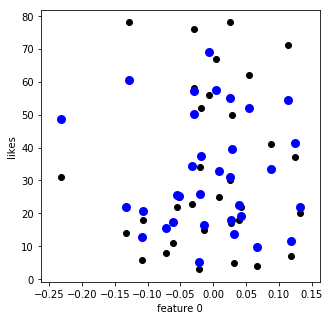

(47, 47) (47, 47)


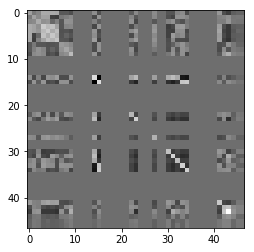

[-0.05607224  0.05675224  0.04026938 -0.07083878 -0.0599739  -0.0838678
 -0.07877072 -0.04511433  0.02139277  0.07840166  0.          0.          0.
  0.         -0.03929196  0.03929196  0.          0.          0.          0.
  0.          0.          0.0428075   0.06505785  0.          0.          0.
 -0.06831718  0.          0.          0.08344697 -0.0900752   0.03861125
 -0.06416606  0.07156219  0.          0.          0.          0.          0.
  0.          0.0501191   0.11071217  0.1150322  -0.02577032  0.04259366
  0.04274849]


In [8]:
"""
Engineer data and fit basic models for use in feature selection
"""

# Get rid of samples with erratic properties, as well as outliers
    
keep = (likes < 10000) & (likes > 1) #& (ntags < 18)
keep = dfp.apply(features.not_in_list,args=[u'fashion',0],axis=1).values & keep

if bytag:
    likeOrder = likes.argsort()
    keep = np.zeros(nposts0, dtype=bool)
    keep[ likeOrder[int(nposts0*.05):int(nposts0*.90)].tolist() ] = True
    followOrder = followers.argsort()
    keep[ followOrder[int(nposts0*.85):].tolist() ] = False
    
    meanOrder = meanlikes2.argsort()
    keep[ meanOrder[:int(nposts0*.05)].tolist() ] = False
    keep[ meanOrder[int(nposts0*.95):].tolist() ] = False
    keep = keep & (meanlikes2 > 0.00001)

elif True:
    likeOrder = likes.argsort()
    keep = np.zeros(nposts0, dtype=bool)
    keep[ likeOrder[int(nposts0*.05):int(nposts0*.90)].tolist() ] = True

goodData = data[keep,:]
y = y_orig[keep]


# Split into test and training sets

nposts = len(goodData)
test = ((np.arange(nposts) % 10) == 0) | ((np.arange(nposts) % 10) == .3)
crossval = ((np.arange(nposts) % 10) == 1) | ((np.arange(nposts) % 10) == .3)
train = np.logical_not(test) & np.logical_not(crossval)
ntrain = len(np.where(train)[0])
ncross = len(np.where(crossval)[0])


# Run regression with each feature missing
# so that we can see each feature's effect on the R^2 score

MSE_results = np.zeros(nfeatures)
R2S_results = np.zeros(nfeatures)

for i in range(nfeatures):

    featureList = [True]*nfeatures
    featureList[i] = False
    
    temp = goodData[:,featureList]

    data_train = temp[train,:]
    data_cross = temp[crossval,:]
    data_test = temp[test,:]

    y_train = y[train]
    y_cross = y[crossval]
    y_test = y[test]

    regr = linear_model.LinearRegression()
    regr.fit(data_train, y_train)

    y_pred = regr.predict(data_cross)

    MSE_results[i] = MSE(y_cross, y_pred)
    R2S_results[i] = R2S(y_cross, y_pred)
    
    if verbose > 2:
        print 'Without feature %02i:'%i
        print 'MSE: %8f'%MSE_results[i]
        print 'R2S: %8f'%R2S_results[i]
    

# Run regression on all features

data_train = goodData[train,:]
data_cross = goodData[crossval,:]
data_test = goodData[test,:]

y_train = y[train]
y_cross = y[crossval]
y_test = y[test]

regr = linear_model.LinearRegression()
regr.fit(data_train, y_train)

y_pred = regr.predict(data_cross)

MSEall = MSE(y_cross, y_pred)
R2Sall = R2S(y_cross, y_pred)

print ''
print 'With all features:'
print 'MSE: %8f'%MSEall
print 'R2S: %8f'%R2Sall


print 'Features by order of importance: '
print R2S_results.argsort()
    
if True:

    fig = plt.figure(figsize=[5,5])
    feat = 0
    rescale = lambda x: x*(max_y-min_y)+center_y
    plt.scatter(data_cross[:,feat], rescale(y_cross),  color='black')
    plt.scatter(data_cross[:,feat], rescale(y_pred), color='blue', linewidth=3)
    plt.ylabel('likes')
    plt.xlabel('feature %d'%(feat,))
    plt.show()

    # Calculate convariances of features and rescale value range for plotting if necessary
    cov = np.cov(np.append(data_train,y_train.reshape([ntrain,1]),axis=1).transpose())
    if False:
        rescale = (lambda x: np.sqrt(x) if (x >= 0) else -np.sqrt(-x))
        covplot = rescale(cov)
    else:
        covplot = cov
    
    # Find good bounds for plotting covariances
    # Since covariances can be negative and we want to keep this information in the plot,
    # we need to look at the distribution of negative and positive values.
    indices = (cov >= 0)
    print indices.shape, cov.shape
    covplot[indices] = np.power(cov[indices],.3)
    meanpos = np.mean(covplot[indices])
    
    indices = (cov < 0)
    covplot[indices] = -np.power(-cov[indices],.3)
    meanneg = np.mean(covplot[indices])
    
    if False:
        covplot = np.append(covplot[:,:38],covplot[:,41:],axis=1)
        covplot = np.append(covplot[:,:9],covplot[:,30:],axis=1)
        covplot = np.append(covplot[:38,:],covplot[41:,:],axis=0)
        covplot = np.append(covplot[:9,:],covplot[30:,:],axis=0)
        limit = np.max( np.array([-meanneg,meanpos]) )*0.3
        plt.imshow(covplot,cmap='bwr',vmin=-limit,vmax=limit)
    else:
        plt.imshow(covplot,cmap='gray')
    plt.show()
    print cov[-1,:] #, data_test[1,:]


In [13]:
"""
Test models
"""

# Run regression on test set with most informative features

feature_helps = R2Sall > R2S_results + .0001
feature_helps_alot = R2Sall > R2S_results + .02
if np.sum(feature_helps_alot) > nfeatures*.5:
    featureList = feature_helps_alot
elif np.sum(feature_helps) > np.ceil(nfeatures*.5):
    featureList = np.median(R2S_results) > R2S_results
elif np.sum(feature_helps) >= 1:
    featureList = feature_helps
else:
    order = R2S_results.argsort()
    featureList = np.arange(nfeatures) == order[0]
print featureList, np.sum(feature_helps_alot) , np.sum(feature_helps)



# Run regression using most informative features

print ''

temp = goodData[:,featureList]

data_train = temp[train,:]
data_cross = temp[crossval,:]
data_test = temp[test,:]

y_train = y[train]
y_cross = y[crossval]
y_test = y[test]

regr = linear_model.LinearRegression()
regr.fit(data_train, y_train)
y_pred = regr.predict(data_cross)
print ''
print 'Cross Validation with best features:'
print 'MSE: %8f'%MSE(y_cross, y_pred)
print 'R2S: %8f'%R2S(y_cross, y_pred)
print 'Spearman: %8f'%pearsonr(y_cross,y_pred)[0]

regr = linear_model.LinearRegression()
regr.fit(data_train, y_train)
y_pred = regr.predict(data_test)
print ''
print 'Test set with best features:'
print 'MSE: %8f'%MSE(y_test, y_pred)
print 'R2S: %8f'%R2S(y_test, y_pred)
print 'Spearman: %8f'%pearsonr(y_test,y_pred)[0]

ntest = y_test.shape[0]
y_pred = regr.predict(data_test)
yorder = y_pred.argsort()
mean_y = np.mean(y_test)
mean_yp = np.mean(y_test[yorder[int(ntest*.7):]])
mean_y0 = mean_y*(max_y-min_y) + min_y
mean_yp0 = mean_yp*(max_y-min_y) + min_y
print ''
print 'Average # likes in test set: %.3f   Average # likes in suggested posts: %.3f'%(mean_y0, mean_yp0)
print 'Average increase in likes: %.3f   Total # samples: %d'%(mean_yp0/mean_y0 - 1.,ntest)



# Run regression using most informative image features

print ''

imageFeatures = np.ones(featureList.shape,dtype=bool)
imageFeatures[-(nMetaFeatures):] = False
temp = goodData[:,(featureList & imageFeatures)]

data_train = temp[train,:]
data_cross = temp[crossval,:]
data_test = temp[test,:]

y_train = y[train]
y_cross = y[crossval]
y_test = y[test]

regr = linear_model.LinearRegression()
regr.fit(data_train, y_train)
y_pred = regr.predict(data_cross)
print ''
print 'Cross Validation with best features without user data:'
print 'MSE: %8f'%MSE(y_cross, y_pred)
print 'R2S: %8f'%R2S(y_cross, y_pred)
print 'Spearman: %8f'%pearsonr(y_cross,y_pred)[0]

regr = linear_model.LinearRegression()
regr.fit(data_train, y_train)
y_pred = regr.predict(data_test)
print ''
print 'Test set with best features without user data:'
print 'MSE: %8f'%MSE(y_test, y_pred)
print 'R2S: %8f'%R2S(y_test, y_pred)
print 'Spearman: %8f'%pearsonr(y_test,y_pred)[0]

ntest = y_test.shape[0]
y_pred = regr.predict(data_test)
yorder = y_pred.argsort()
mean_y = np.mean(y_test)
mean_yp = np.mean(y_test[yorder[int(ntest*.7):]])
mean_y0 = mean_y*(max_y-min_y) + min_y
mean_yp0 = mean_yp*(max_y-min_y) + min_y
print ''
print 'Average # likes in test set: %.3f   Average # likes in suggested posts: %.3f'%(mean_y0, mean_yp0)
print 'Average increase in likes: %.3f   Total # samples: %d'%(mean_yp0/mean_y0 - 1.,ntest)



# Run with just metadata... Compare these numbers to above to see if images help

print ''

temp = goodData[:,(featureList & np.logical_not(imageFeatures))]

data_train = temp[train,:]
data_cross = temp[crossval,:]
data_test = temp[test,:]

y_train = y[train]
y_cross = y[crossval]
y_test = y[test]

regr = linear_model.LinearRegression()
regr.fit(data_train, y_train)
y_pred = regr.predict(data_cross)
print ''
print 'Cross Validation with just user data:'
print 'MSE: %8f'%MSE(y_cross, y_pred)
print 'R2S: %8f'%R2S(y_cross, y_pred)
print 'Spearman: %8f'%pearsonr(y_cross,y_pred)[0]

regr = linear_model.LinearRegression()
regr.fit(data_train, y_train)
y_pred = regr.predict(data_test)
print ''
print 'Test set with just data:'
print 'MSE: %8f'%MSE(y_test, y_pred)
print 'R2S: %8f'%R2S(y_test, y_pred)
print 'Spearman: %8f'%pearsonr(y_test,y_pred)[0]

ntest = y_test.shape[0]
y_pred = regr.predict(data_test)
yorder = y_pred.argsort()
mean_y = np.mean(y_test)
mean_yp = np.mean(y_test[yorder[int(ntest*.7):]])
mean_y0 = mean_y*(max_y-min_y) + min_y
mean_yp0 = mean_yp*(max_y-min_y) + min_y
print ''
print 'Average # likes in test set: %.3f   Average # likes in suggested posts: %.3f'%(mean_y0, mean_yp0)
print 'Average increase in likes: %.3f   Total # samples: %d'%(mean_yp0/mean_y0 - 1.,ntest)

[ True False False False  True False  True  True False  True False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False  True False  True  True] 1 8


Cross Validation with best features:
MSE: 0.000008
R2S: 0.817823
Spearman: 0.925140

Test set with best features:
MSE: 0.000004
R2S: 0.884746
Spearman: 0.941925

Average # likes in test set: 33.000   Average # likes in suggested posts: 59.400
Average increase in likes: 0.800   Total # samples: 33


Cross Validation with best features without user data:
MSE: 0.000040
R2S: 0.040829
Spearman: 0.256311

Test set with best features without user data:
MSE: 0.000034
R2S: 0.068181
Spearman: 0.301129

Average # likes in test set: 33.000   Average # likes in suggested posts: 37.300
Average increase in likes: 0.130   Total # samples: 33


Cross Validation with just user data:
MSE: 0.000008
R2S: 0.814288
Spearman: 0

In [12]:
"""
Neural Net
"""

# Note: This did not produce noticeably better results than the linear model 
# and was highly sensitive to initial conditions. I thus opted for the more
# interpretable linear model above.


from sklearn.neural_network import MLPRegressor
from decimal import Decimal


# Set up data

if True:
    temp = goodData[:,featureList]
elif True:
    imageFeatures = np.ones(featureList.shape,dtype=bool)
    imageFeatures[-(nMetaFeatures):] = False
    temp = goodData[:,imageFeatures]
elif True:
    imageFeatures = np.ones(featureList.shape,dtype=bool)
    imageFeatures[-(nMetaFeatures):] = False
    temp = goodData[:,(featureList & imageFeatures)]
else:
    temp = goodData[:,(featureList & np.logical_not(imageFeatures))]


data_train = temp[train,:]
data_cross = temp[crossval,:]
data_test = temp[test,:]

y_train = y[train]
y_cross = y[crossval]
y_test = y[test]



# Adapted from sklearn tutorial

h = .02  # step size in the mesh

alphas = np.logspace(-9, 9, 41)

regressors = []
scores = []
R2scores = []
for alpha in alphas:
    
    # See how neutal network model performs with various alpha values (i.e. amounts of regularization)
    
    regr = MLPRegressor(alpha=alpha, hidden_layer_sizes=(100,), random_state=1, shuffle=True, activation='identity')
    regressors.append(regr)
    
    regr.fit(data_train, y_train)
    score = regr.score(data_test, y_test)
    scores.append(score)
    
    y_pred = regr.predict(data_test)
    
    print 'Alpha: %.2E  Score: %.2E  Spearman: %8f'%(Decimal(alpha), Decimal(score), pearsonr(y_test,y_pred)[0])
    

In [11]:
"""
Save model so it can be used in website's backend
"""

import pickle

imageFeatures = np.ones(featureList.shape,dtype=bool)
imageFeatures[8:] = False
temp = goodData[:,(featureList & imageFeatures)]

data_train = temp[train,:]
data_cross = temp[crossval,:]
data_test = temp[test,:]

y_train = y[train]
y_cross = y[crossval]
y_test = y[test]

regr = linear_model.LinearRegression()
regr.fit(data_train, y_train)

filename = 'models/LR_model_cake.sav'
pickle.dump([regr,(featureList&imageFeatures), min_y,max_y,center_y, minvals,maxvals,centervals], open(filename, 'wb'))

In [14]:
print 'Regression coefficients: ',regr.coef_
print 'Output bias: ',regr.intercept_

Regression coefficients:  [ 0.00471292 -0.01078447  0.63256127]
Output bias:  0.00151652353047


In [15]:
# An example of the type of exploratory analysis used to engineer features.
# See exploration.ipynb for more examples.

imagesG = np.mean(images,3)

likes = likes/np.max(likes)
likeorder = likes.argsort()

plt.scatter(ntags[likeorder[:int(nposts0*.95)]],likes[likeorder[:int(nposts0*.95)]])

fig = plt.figure(figsize=[15,15])


# Plot the 'average' of images at different quartiles to see what compositional features may be most informative

ax1 = fig.add_subplot(141)
keep = np.zeros(nposts0,dtype=bool)
keep[likeorder[:int(nposts0*.25)]] = True
print np.where(keep)[0].shape,
image = np.mean(imagesG[keep],0)
ax1.imshow(image/255.)

ax2 = fig.add_subplot(142)
keep = np.zeros(nposts0,dtype=bool)
keep[likeorder[int(nposts0*.25):int(nposts0*.5)]] = True
print np.where(keep)[0].shape,
image = np.mean(imagesG[keep],0)
ax2.imshow(image/255.)

ax3 = fig.add_subplot(143)
keep = np.zeros(nposts0,dtype=bool)
keep[likeorder[int(nposts0*.5):int(nposts0*.75)]] = True
print np.where(keep)[0].shape,
image = np.mean(imagesG[keep],0)
ax3.imshow(image/255.)

ax4 = fig.add_subplot(144)
keep = np.zeros(nposts0,dtype=bool)
keep[likeorder[int(nposts0*.75):]] = True
print np.where(keep)[0].shape,
image = np.mean(imagesG[keep],0)
ax4.imshow(image/255.)

#plt.show()

(124,) (125,) (124,) (125,)

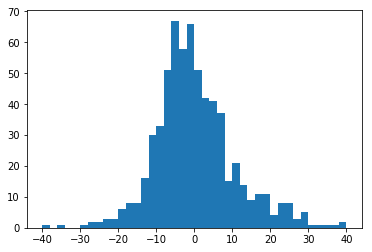

Standard deviation of residuals: 12.3932283917


In [22]:
# Characterize residuals to determine if error model should be adjusted

residuals = (y_train-regr.predict(data_train))
plt.hist( residuals*(max_y-min_y), bins=40, range=(-40,40))
plt.show()

print 'Standard deviation of residuals:', np.sqrt( np.var( residuals*(max_y-min_y) ))